## RAMA 2: Vamos a estudiar el hamiltoniano asociado a una cadena de moléculas sin interacción dipolar. 

In [2]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import sympy as sp
from qutip import *
from qutip import (about, destroy, entropy_vn, expect, hinton, jmat, ptrace, qeye, steadystate, tensor, wigner)
from mpl_toolkits.mplot3d import Axes3D # hacer gráfico 3Dfrom numpy import *
%matplotlib inline
from numpy import *
from scipy.misc import *
from scipy.special import *

In [4]:
from sympy import *

r, k=symbols('r, k')

def j1(r):
    return sin(r)/(r**2)+cos(r)/r

def j2(r):
    return (3/r**3-1/r)*sin(r)-3*(cos(r)/r**2)


def j0(r):
    return sin(r)/r

def tau(n, r):
    return jn(n, r)

def h(n, t):
    return jn(n,r)+1j*yn(n,r)

def Ptau(n, r):
    return 1/r*diff(r*jn(n,r), r, 1)

def Ph(n, r):
    return 1/r*diff(r*h(n,r), r, 1)


In [9]:
def a0(x): #esta función convierte una distancia x en metros a unidades atómicas a_0
    return x/(5.29177249e-11) 
#########

def tau(t): #convertir de segundos a tiempo en unidades atómicas
    return t/2.418884332268184938e-17

##################

def dby(d): #d está en debyes, pasamos a unidades atómocas ea_0
    return (d*0.393430307)


def Fre(nu): 
    return (nu/6.579683905044601137e15)


def Freo(omega):
    return (omega/4.13413732380622433e16)


def Eh(E): #se ingresa una energía en eV la devuelve en E_h
    
    return E/ 27.211386245988

In [287]:
#parámetros del sistema
M=15
N=100

#parámetros de la nano esfera

c= 299792458
nu=c/197.49e-9

omega_p=Freo(2*np.pi*nu) #se ingresa en eV, luego se transforma en Hartrees. 
omega_m=omega_p

R=a0(10e-9) #urgente determinar el R asociado a una frecuencia dada. 

epsilon_2=6.05

d=dby(1.811)  #el dipolo se ingresa en debyes

#r=a0(6.27e-10)    # separación horizontal entre dipolos 

r1=a0(6.27e-10)  

alpha=0.1

k=[np.sqrt(epsilon_2)*omega_p/137, omega_p/137]
A=[(1+alpha)*R, R]

In [8]:
##### para los coeficientes

def tau(n,i,l):
    r=k[i]*a[l]
    return spherical_jn(n,r)

def h(n,i,l):
    r=k[i]*a[l]
    return spherical_jn(n,r) + 1j * spherical_yn(n,r)


def Ptau(n,i,l):
    return (n*tau(n-1,i,l)-(n+1)*tau(n+1, i, l))/(2*n+1)+tau(n, i, l)/(k[i]*a[l])

def Ph(n, i, l):
    return (n*h(n-1,i,l)-(n+1)*h(n+1, i, l))/(2*n+1)+h(n, i, l)/(k[i]*a[l])
 
def T(n, B):

    f=0
            
    if B=='H':
        return  ( k[f+1]*(Ptau(n, f+1,f)*h(n, f+1, f)-tau(n, f+1, f)*Ph(n, f+1, f)) )/( k[f+1]*Ptau(n, f+1,f)*h(n, f, f)- k[f]*tau(n, f+1, f)*Ph(n, f, f))
        
    if B=='V':
        return  ( k[f+1]*(tau(n, f+1,f)*Ph(n, f+1, f)-Ptau(n, f+1, f)*h(n, f+1, f)) )/( k[f+1]*tau(n, f+1,f)*Ph(n, f, f)- k[f]*Ptau(n, f+1, f)*h(n, f, f))

        

def AM(n):
    return T(n, 'H')

def AN(n):
    return T(n, 'V')

In [288]:
def Plpmv(n,m,theta): #derivative of the associated Legendre polinomials 

    return ((n*np.cos(theta)*lpmv(n, m, np.cos(theta))-(n+m)*lpmv(n-1,m, np.cos(theta)))/np.sqrt((1-np.cos(theta)**2)) )

def h(n, u): #spherical Hankel function of the first kind 
    return spherical_jn(n,u) + 1j * spherical_yn(n,u)

def M(A,B,m, n, k, R): #(e,o), (p, np) 

    result=[0] #no tenemos componente radial
    r=R[0]
    theta=R[1]
    phi=R[2]

    hn=spherical_jn(n,k*r) +1j*spherical_yn(n,k*r)

    if A=='e':
    
        if B=='p':
            result.append( -m/(np.sin(theta))*(hn)*lpmv(m, n, np.cos(theta))*np.sin(m*phi) )
            result.append( -hn*Plpmv(n,m,theta) *np.cos(m*phi)  )
        else:
            result.append( -m/(np.sin(theta))*(spherical_jn(n, k*r))*lpmv(m, n, np.cos(theta))*np.sin(m*phi))
            result.append( -spherical_jn(n, k*r)*Plpmv(n,m,theta) *np.cos(m*phi)  )

    if A=='o':

        if B=='p':
            result.append( m/(np.sin(theta))*(hn)*lpmv(m, n, np.cos(theta))*np.cos(m*phi) )
            result.append( -hn*Plpmv(n,m,theta) *np.sin(m*phi)  )
        else:
            result.append( m/(np.sin(theta))*(spherical_jn(n, k*r))*lpmv(m, n, np.cos(theta))*np.cos(m*phi))
            result.append( -spherical_jn(n, k*r)*Plpmv(n,m,theta)*np.sin(m*phi) )

    return result




def N(A,B,m, n, k, R): # (e,o), (p, np) 

    result=[] 
    r=R[0]
    theta=R[1]
    phi=R[2]


    Pj= (n*spherical_jn(n-1, k*r)-(n+1)*spherical_jn(n+1, k*r))/(2*n+1)+spherical_jn(n, k*r)/(k*r)

    Ph= (n*h(n-1, k*r)-(n+1)*h(n+1, k*r))/(2*n+1)+h(n, k*r)/(k*r)

    if A=='e':
    
        if B=='p':
            result.append( n*(n+1)/(k*r)*h(n, k* r)*lpmv(m, n, np.cos(theta))*np.cos(m*phi) )

            result.append( Ph*Plpmv(n,m,theta) *np.cos(m*phi)  )

            result.append(-Ph*(m/np.sin(theta))*lpmv(m, n, np.cos(theta))*np.sin(m*phi)) 

        else:
            result.append( n*(n+1)/(k*r)*spherical_jn(n, k*r)*lpmv(m, n, np.cos(theta))*np.cos(m*phi) )

            result.append(  Pj*Plpmv(n,m,theta) *np.cos(m*phi)  )

            result.append( -Pj*(m/np.sin(theta))*lpmv(m, n, np.cos(theta))*np.sin(m*phi)  ) 

    if A=='o':

        if B=='p':
            result.append( n*(n+1)/(k*r)*h(n, k*r)*lpmv(m, n, np.cos(theta))*np.sin(m*phi) )

            result.append( Ph*Plpmv(n,m,theta) *np.sin(m*phi)  )

            result.append(Ph*(m/np.sin(theta))*lpmv(m, n, np.cos(theta))*np.cos(m*phi)) 

        else:
            result.append( n*(n+1)/(k*r)*spherical_jn(n, k*r)*lpmv(m, n, np.cos(theta))*np.sin(m*phi) )

            result.append(Pj*Plpmv(n,m,theta) *np.sin(m*phi)  )

            result.append( Pj*(m/np.sin(theta))*lpmv(m, n, np.cos(theta))*np.cos(m*phi)  ) 

    return result

# **ACÁ INICIA EL CÓDIGO**

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import sympy as sp
from qutip import *
from qutip import (about, destroy, entropy_vn, expect, hinton, jmat, ptrace, qeye, steadystate, tensor, wigner)
from mpl_toolkits.mplot3d import Axes3D # hacer gráfico 3Dfrom numpy import *
%matplotlib inline
from numpy import *
from scipy.misc import *
from scipy.special import *

In [289]:
def a0(x): #esta función convierte una distancia x en metros a unidades atómicas a_0
    return x/(5.29177249e-11) 
#########

def tau(t): #convertir de segundos a tiempo en unidades atómicas
    return t/2.418884332268184938e-17

##################

def dby(d): #d está en debyes, pasamos a unidades atómocas ea_0
    return (d*0.393430307)


def Freo(omega):
    return (omega/4.13413732380622433e16)


In [307]:
#parámetros del sistema
M=15
N=100

#parámetros de la nano esfera

c= 299792458
nu=c/197.49e-9

omega_p=Freo(2*np.pi*nu) #se ingresa en eV, luego se transforma en Hartrees. 
omega_m=omega_p

R=a0(10e-9) #urgente determinar el R asociado a una frecuencia dada. 

epsilon_2=6.05

d=10*dby(1.811)  #el dipolo se ingresa en debyes

r=a0(6.27e-10)   #distancia natural entre dipolos

alpha=0.05

A=(1+alpha)*R

In [291]:
def posiciones (y, M):

    r=[]
    
    phi=np.linspace(0, 2*np.pi, M)
    theta=np.pi/2

    for i in phi:

        X=y*np.sin(theta)*np.cos(i)
        Y=y*np.sin(theta)*np.sin(i)
        Z=y*np.cos(theta)
        r.append([X,Y,Z])
       

    return np.array(r)


# Función para encontrar los vectores aleatorios que definen cada momento

In [292]:
def Momentos(M): #función que entrega un vector que en cada componente tiene las componentes x,y,z 
    #del vector unitario que determina cada dipolo en una red de N dipolos.
    
    momentos=[]
    
    for i in range (M):
        #ahora vamos a determinar las direcciones aleatorias theta y phi de cada dipolo
        np.random.seed()
        theta=np.random.uniform(0, np.pi)
        phi=np.random.uniform(0, 2*np.pi)

        x1=np.sin(theta)*np.cos(phi)
        y1=np.sin(theta)*np.sin(phi)
        z1=np.cos(theta)

        momentos.append([x1,y1,z1]) #vector que en cada componente tiene en ángulo theta y phi asociado 
    return (np.real(momentos))

In [342]:
M=115
momentos=Momentos(M)
P=posiciones(A, M)

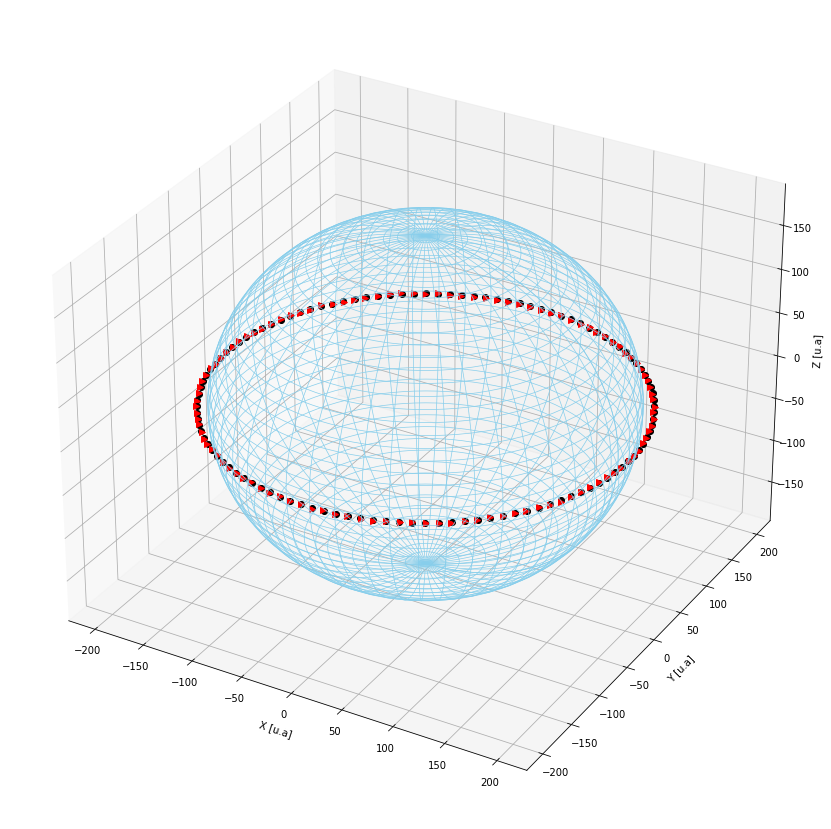

In [343]:
fig, ax=plt.subplots(figsize=(15,15), subplot_kw=dict(projection='3d'))


#graficamos la nanoesfera
theta=np.linspace(0,np.pi,100)
phi=np.linspace(0,2*np.pi,100)

Theta,Phi=np.meshgrid(theta,phi)

X=R*np.sin(Theta)*np.cos(Phi) 
Y=R*np.sin(Theta)*np.sin(Phi)
Z=R*np.cos(Theta)

ax.plot_wireframe(X,Y,Z,lw=0.7, color='skyblue') #dibujamos el casquete esférico

#graficamos los dipolos y su dirección
for i in range (len(P)): #en P están los centros de masa de los momentos
    #en momentos está el vector del momento. 
    
    x1=momentos[i][0]+P[i][0]
    y1=momentos[i][1]+P[i][1]
    z1=momentos[i][2]+P[i][2]

    ax.plot((P[i][0],),(P[i][1],), (P[i][2],), marker='o',c='k') #dibujamos el centro del dipolo
    ax.plot((P[i][0], x1 ) ,(P[i][1],y1), (P[i][2],z1  ),  c='r') #dibujamos la línea
    ax.plot((x1,),(y1,),(z1,),'->',c='r') #dibujamos la dirección
    
 

ax.set_xlabel('X [u.a]')
ax.set_ylabel('Y [u.a]')
ax.set_zlabel('Z [u.a]')
plt.show()

# Función para determinar $\hat{\sigma}_+, \hat{\sigma}_-, \hat{\sigma}_3$ de cada dipolo

In [295]:
def sigmaT(M,N):
    l = 2  # número de estados del dipolo. 
    Sigma = []
    for i in range(M):
        operators = []
        for j in range(M): #si el índice es igual a la matriz que quiero entonces pongo el destroy 
            #de resto pongo el qeye, luego al final pongo la matriz unitaria asociada a la radiación.
            if j != i:
                operators.append(qeye(l))
            else:
                operators.append(destroy(l))
        
        operators.append(qeye(N+1))
        sigma_plus=tensor(operators)
        Sigma.append(np.array(sigma_plus))

    return np.real(Sigma)

In [296]:
def Base(M,N):
    B=np.eye(2**M*(N+1))
    return np.linalg.eig(B)[1]

In [298]:
def aT(M,N): #función que entrega la representación matricial del operador a en la base de 
    #N fotones y M dipolos. 
    L=[]
    for i in range(M):
        L.append(qeye(2))
    L.append(destroy(N+1))
    a=tensor(L) 
    return (np.real(np.array(a)))

In [299]:
def Hdip0_(sigma):
    
    s=sigma.shape
    H_0=np.zeros((s))

    sp=sigma
    sm=np.transpose(sp)
    H_0+=sp@sm-sm@sp
        
    return (0.5*omega_m*H_0 )


In [300]:
def Hdip0(M, sigmas):
    
    s=sigmas[0].shape
    H_0=np.zeros((s))
    
    for i in range (M):
        sp=sigmas[i]
        sm=np.transpose(sp)
        H_0+=sp@sm-sm@sp
        
    return (0.5*omega_m*H_0 )

In [301]:
def vecinos(i, M):
    if i >= M:
        return "error"
    V = []
    if i != M - 1:
        V.append(i + 1)
    return V

In [302]:
def vecinosp(i, M):

    V=vecinos(i, M)
    
    if i==0: 
        V.append(M-1)       
    return V

In [303]:
def Ein(i, M, Momentos, sigmas): 
    """
    siempre consideramos situaciones sin RWA y con condiciones de frontera periodicas
    """ 
    

    V = vecinosp(i, M)
        
    
    sum1 = 0
    sum2 = 0
    
    s = sigmas[0].shape

    if M == 1:
        return np.zeros(s)
    
    
    if V:

        for k in V:
            sum1 += (sigmas[i] + np.transpose(sigmas[i])) @ (sigmas[k] + np.transpose(sigmas[k]))
            sum2 += np.dot(Momentos[i], Momentos[k])-3*np.dot(Momentos[i], [1,0,0])*np.dot(Momentos[k], [1,0,0])
        
        return sum2*sum1

    else:
        return np.zeros(s)

In [304]:
def HdipI_(i, M, sigmas, Momentos):

    s=sigmas[0].shape
    H_2=np.zeros((s))
 
    H_2=(d**2/r**3)*Ein(i,M,momentos, sigmas) 

    return H_2


In [305]:
def HdipI(M, momentos, sigmas):   

    s=sigmas[0].shape
    H_2=np.zeros((s))
    
    for i in range (M):
        H_2+=Ein(i,M,momentos, sigmas) 
        
    return (d**2/r**3)*H_2

In [334]:
print(A*2*np.pi/105)
print(a0(6.27e-10) )

11.873498566034511
11.84858194838985


Para poder lograr un acople fuerte entre dipolos necesitaríamos 105 dipolos alrededor de la nanoesfera, sino la estructura del hamiltoniano no se ve afectada. 

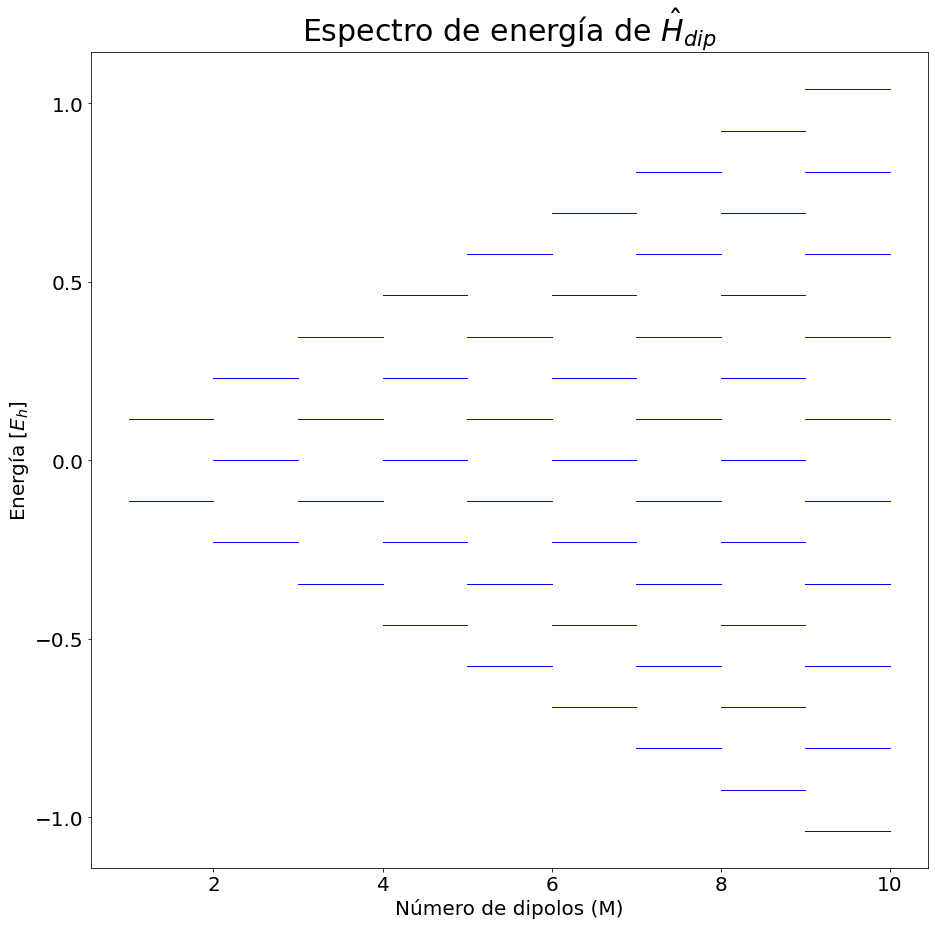

In [333]:
#parámetros de la nano esfera

c= 299792458
nu=c/197.49e-9

omega_p=Freo(2*np.pi*nu) #se ingresa en eV, luego se transforma en Hartrees. 
omega_m=omega_p

R=a0(10e-9) #urgente determinar el R asociado a una frecuencia dada. 

epsilon_2=6.05

d=10*dby(1.811)  #el dipolo se ingresa en debyes

r=a0(6.27e-10)   #distancia natural entre dipolos

alpha=0.05

A=(1+alpha)*R


M=9
N=0

momentos=Momentos(M)
sigmas=sigmaT(M, N)

fig1,ax1=plt.subplots(1,1, figsize=(15,15))


for i in range(1, M+1):
    U0=Hdip0(i, sigmas)
    U1=HdipI(i, momentos, sigmas)
    
    E0=np.real(np.linalg.eigvals(U0))
    E1=np.real(np.linalg.eigvals(U1))
    E2=np.real(np.linalg.eigvals(U0+U1))


    for j in range(len(E2)):
        X=[int(i), int(i+1)]
        ax1.plot(X,[E2[j],E2[j]], c='b', lw=1) 
        #ax1.plot(X,[E0[j],E0[j]], c='k')
        
              

ax1.set_xlabel('Número de dipolos (M)', fontsize=20)
ax1.set_ylabel(r'Energía$~[E_h]$', fontsize=20)
ax1.set_title('Espectro de energía de $\hat{H}_{dip}$', fontsize=30)

ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)


plt.show()

# hamiltoniano radiación-materia  en la base completa

### 

\begin{align} 
 \hat{H}_{tot}= \frac{\omega_m}{2} \sum_{i=1}^{  M } \hat{\sigma}_{3j}+\omega_p \hat{a}^{\dagger}\hat{a} + \frac{3}{2}d\sqrt{\frac{3 \omega_p R^3}{
  (2\epsilon_2+1)^{3/2}}} \left[\sum_{i=1}^{M}\sum_{\hat{k}=\hat{x}, \hat{y}, \hat{z}} \frac{ (3 \cos \theta_{0_ik} \cos \theta_{0_id_i}-\cos \theta_{d_ik}) }{r_{0d_i}^3}(\hat{\sigma}_{+i}+\hat{\sigma}_{-i}) \right ] (\hat{a}+\hat{a}^\dagger) 
\end{align}

In [335]:
def Hrad0(a):
    return omega_p*(np.transpose(a)@a)

In [336]:
def HradI_(i, momento, sigma, P, a):
    
    K=np.array([[1,0,0], [0,1,0],[0,0,1]])
    
    H_rad1=np.zeros(sigma.shape)
    
    p= P/y
    m=momento
    sp=sigma
    sm=np.transpose(sp)
    
    anda=0
    
    for k in K:
        anda+=3*np.dot(p,k)*np.dot(p,m)-np.dot(m,k)
        

    landa=(3/2)*d*np.sqrt((3*omega_p*R**3)/(2*epsilon_2+1)**(3/2))*(1/y**3)*anda
    
    H_rad1+=landa*(sm+sp)
      
    return ( np.real( H_rad1@(a+np.transpose(a))), landa)

In [337]:
def HradI(M, momentos, sigmas, P, a, y):

    K=np.array([[1,0,0], [0,1,0],[0,0,1]])
    
    H_rad1=np.zeros(sigmas[0].shape)
    
    for i in range (M):
        
        p= P[i]/y
        m=momentos[i]
        sp=sigmas[i]
        sm=np.transpose(sp)
    
        anda=0
    
        for k in K:
            anda+=3*np.dot(p,k)*np.dot(p,m)-np.dot(m,k)
        
        H_rad1+=anda*(sm+sp) 
      
    return ( np.real( (3/2)*d*np.sqrt((3*omega_p*R**3)/(2*epsilon_2+1)**(3/2))*(1/y**3)*H_rad1@(a+np.transpose(a))), landa)

Vamos a definir una función que nos permita conocer para diferentes configuraciones de M dipolos entre qué valos varía el factor lamnda

In [314]:
def landa (M ,iter, P): #valor del factor de acople 
 
    K=np.array([[1,0,0], [0,1,0],[0,0,1]])
    anda=[]

    for j in range (iter):
        Landa=0
        momentos=Momentos(M)
        
        for i in range(M):
            p= (1/y)*P[i]
            m=momentos[i]


            for k in K:
                Landa+=3*np.dot(p,k)*np.dot(p,m)-np.dot(m,k)

        
        anda.append(3*d*np.sqrt((3*omega_p*R**3)/(2*epsilon_2+1)**(3/2))*(1/y**3)*Landa)

    return (np.abs(np.min(anda)), np.abs(np.max(anda)))

In [315]:
#parámetros del sistema
M=15

#parámetros de la nano esfera

c= 299792458
nu=c/197.49e-9

omega_p=Freo(2*np.pi*nu) #se ingresa en eV, luego se transforma en Hartrees. 
omega_m=omega_p

R=a0(10e-9) #urgente determinar el R asociado a una frecuencia dada. 

epsilon_2=6.05

d=8*dby(1.811)  #el dipolo se ingresa en debyes

r=A[0]*M/(2*np.pi)

alpha=0.05 #los dipolos están a una distancia de 5% del radio desde la superficie de la esfera. 

k=[np.sqrt(epsilon_2)*omega_p/137, omega_p/137]
A=[(1+alpha)*R, R]


y=A[0] #distancia vertical entre el centro de la nano esfera y la línea en dónde están ubicados 
#los dipolos 

momentos=Momentos(M)
P=posiciones(A[0], M)
#sigmas=sigmaT(M,N)

landa(M, 1000, P)

(0.010412394550458995, 0.011482880709503271)

In [349]:
M=10
N=8

omega_p=Freo(2*np.pi*nu) #se ingresa en eV, luego se transforma en Hartrees. 
omega_m=omega_p

R=a0(10e-9) #urgente determinar el R asociado a una frecuencia dada. 

epsilon_2=6.05

d=10*dby(1.811)  #el dipolo se ingresa en debyes

#r=a0(6.27e-10)    # separación horizontal entre dipolos 

alpha=0.05

A=[(1+alpha)*R, R]

y=A[0] #distancia vertical entre el centro de la nano esfera y la línea en dónde están ubicados 
#los dipolos 

r=A[0]*M/(2*np.pi)



a=aT(M,N)
momentos=Momentos(M)
sigmas= sigmaT(M,N)

P=posiciones(A[0], M)


a=aT(M,N)

U1=Hrad0(a)


fig1,ax1=plt.subplots(1,1,figsize=(15,12))

for i in range (1,M+1):

    U0=Hdip0(i, sigmas)
    U2=HradI(i, momentos, sigmas, P, a, y)[0]
    U=U0+U1+U2 
    E=np.real(np.linalg.eigvals(U))
    
    for j in range(len(E)):
        Q=E[j]
        X=[int(i), int(i+1)]
        ax1.plot(X,[Q,Q], c='blue', lw=1)
        
ax1.set_xlabel('Número de dipolos (M)', fontsize=25)
ax1.set_ylabel('Energía $[E_h]$', fontsize=25)
ax1.set_title('Espectro de energía de $\hat{H}_{tot}$', fontsize=30)


ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)

plt.show()


Si no tengo strong coupling entonces no puedo afirmar que se forman polaritones. El factor de acople no depende del número de fotones.  El hamiltoniano total y el de radiación son casi lo mismo, es decir que el hamiltoniano de interacción dipolar lo podemos considerar como una perturbación

## Evolución temporal

In [30]:
# Definimos el tiempo
M=3
N=5
t =np.linspace(0, 42, 84) #42tau=1f segundo
B=Base(M,N)
psi0=B[(len(B)-1)-N] #todos los subsistemas inician en el mismo estado |g1g2...gM,0>, el de más baja energía. 


momentos=Momentos(M)
sigmas= sigmaT(M,N)
P=posiciones(a[0],M)
a=aT(M, N)


In [31]:
U2=Hrad0(a) #radiación en la cavidad

for i in range(M): #queremos estudiar casa sistema por serado
    
    sp=sigmas[i]
    sm=np.transpose(sp)
    s3=sp@sm-sm@sp
    PP=P[i]
    momento=momentos[i]
    
    n=np.transpose(a)@a
    N_e=n+B[N]@np.transpose(B[N])

    #el hamiltoniano de cada subsistema consistiría en quitar la sumatoria, todos parten del mismo estado. 
    

    U0=Hdip0_(sp) #solo dipolos
    U1=HdipI_(i, M, sigmas, momentos, u, p) #energía de interacción entre dipolos
    U3=HradI_(i, momento, sp, PP,a)[0] #interacción radiación dipolos
    U4=U0+U1+U2+U3



    result=mesolve( Qobj(U4), Qobj(psi0), t, [], [Qobj(s3), Qobj(U4), Qobj(n), Qobj(N_e) ]  )

    
    fig, ax=plt.subplots(1,4, figsize=(20,7))
    
    fig.suptitle(r"Dipolo #{}, $N$={}, $\omega_p$={} $E_h$".format(i+1, N, np.round(omega_p,3)), fontsize=24)

    ax[0].plot(t, result.expect[0], label=r"$\langle \sigma_3{} \rangle$".format(i+1),c='r',lw=2)
    ax[0].set_title(" Inversión de población", fontsize=20)
    ax[0].set_xlabel(r"Tiempo $[\tau]$")
    ax[0].set_ylabel(r" $\langle \sigma_3{} \rangle$".format(i+1))
    ax[0].grid()
    plt.tight_layout()



    ax[1].plot(t, result.expect[1], label=r"$\langle \hat{H}_{tot} \rangle$",c='b',lw=2)
    ax[1].set_title(" Energía total", fontsize=20)
    ax[1].set_xlabel(r"Tiempo $[\tau]$")
    ax[1].set_ylabel(r" $\langle \hat{H}_{tot} \rangle [E_h]$")
    ax[1].grid()
    plt.tight_layout()

    ax[2].plot(t, result.expect[2], label=r"$\langle \hat{a}^\dagger \hat{a} \rangle$",c='k',lw=2)
    ax[2].set_title(" Número de fotones", fontsize=20)
    ax[2].set_xlabel(r"Tiempo $[\tau]$")
    ax[2].set_ylabel(r" $\langle \hat{N} \rangle$")
    ax[2].grid()
    plt.tight_layout()


    ax[3].plot(t, result.expect[3], label=r"$\langle \hat{N}_e \rangle$",c='g',lw=2)
    ax[3].set_title(" Número de excitación", fontsize=20)
    ax[3].set_xlabel(r"Tiempo $[\tau]$")
    ax[3].set_ylabel(r" $\langle \hat{N}_e \rangle$")
    ax[3].grid()
    plt.tight_layout()

    plt.show()
                

NameError: name 'HdipI_' is not defined